# Probabilistic Machine Learning in PyMC3

For accompaniying slides, see: https://docs.google.com/presentation/d/1puj4iN70MRVauUmIMAZS0pfANktjdQ5uCP7H8OLPKFk/edit?usp=sharing

Download the NB: https://twiecki.github.io/probabilistic_ml.ipynb

(c) 2016 by [Thomas Wiecki](https://twitter/twiecki) -- [Quantopian Inc.](https://quantopian.com)

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale


import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

sns.set_context('notebook')

<h3>Generating data</h3>

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [2]:
from sklearn.datasets import make_moons
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
print(X)
print(Y[:20])

[[ 1.77780578  0.60758943]
 [ 1.46176517 -0.4475523 ]
 [-0.8189727   0.60739519]
 ..., 
 [-0.15495214 -1.64435644]
 [-0.35557878 -0.34459172]
 [-0.01889003 -1.4519874 ]]
[1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0]


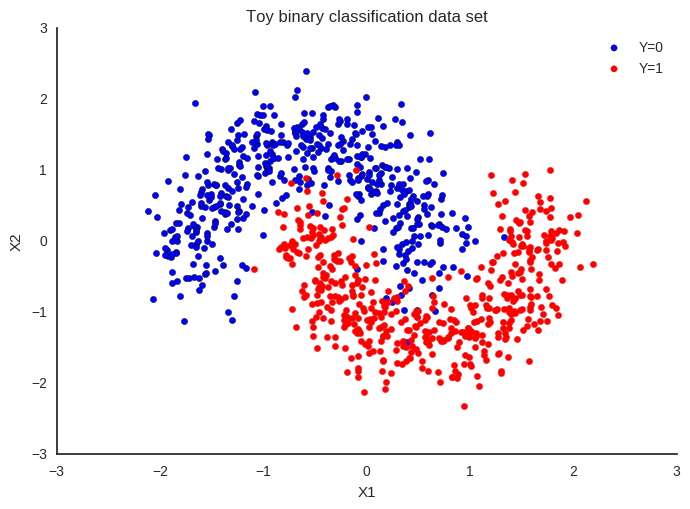

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Y=0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Y=1')
sns.despine(); ax.legend()
ax.set(xlabel='X1', ylabel='X2', title='Toy binary classification data set');

## Perceptron

![](./Simple Neural Network.png)

### Maximum Likelihood

In [4]:
from pymc3 import Model, Flat, Bernoulli
from pymc3.math import dot, sigmoid

n_dim = X.shape[1]

with Model() as perceptron:
    weights = Flat('w', shape=n_dim) # equivalent to no prior at all
    
    linear = dot(X, weights)
    class_prob = sigmoid(linear)
    
    # Binary classification -> Bernoulli likelihood
    Bernoulli('out', class_prob, observed=Y)

In [5]:
with perceptron:
    mle_est = pm.find_MAP()
    
mle_est

{'w': array([ 1.14621181, -2.55110913])}

In [6]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

### Bayesian Perceptron

In [7]:
from pymc3 import Model, Normal, Bernoulli
from pymc3.math import dot, sigmoid

n_dim = X.shape[1] # 2

with Model() as perceptron_prior:
    # Define parameters, specify priors
    weights = Normal('w', mu=0, sd=.1, 
                     shape=n_dim)
    
    linear = dot(X, weights)
    class_prob = sigmoid(linear)
    
    # Binary classification -> Bernoulli likelihood
    Bernoulli('out', class_prob, observed=Y)

In [8]:
with perceptron_prior:
    map_est = pm.find_MAP()
    
map_est

{'w': array([ 0.65948377, -1.05084548])}

### Bayesian Perceptron: Full Posterior inference

In [9]:
from pymc3.variational import advi
with perceptron_prior:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = advi(n=5000)

Iteration 0 [0%]: ELBO = -725.52
Iteration 500 [10%]: Average ELBO = -953.89
Iteration 1000 [20%]: Average ELBO = -843.57
Iteration 1500 [30%]: Average ELBO = -751.3
Iteration 2000 [40%]: Average ELBO = -678.95
Iteration 2500 [50%]: Average ELBO = -593.9
Iteration 3000 [60%]: Average ELBO = -565.22
Iteration 3500 [70%]: Average ELBO = -524.97
Iteration 4000 [80%]: Average ELBO = -506.19
Iteration 4500 [90%]: Average ELBO = -485.86
Finished [100%]: Average ELBO = -475.66


In [10]:
print(v_params.means)
print(v_params.stds)

{'w': array([ 0.66754707, -0.95675624])}
{'w': array([ 0.37981316,  0.40535543])}


### Still often convenient to work with samples

In [11]:
from pymc3.variational import sample_vp
with perceptron_prior:
    trace = sample_vp(v_params, draws=20000)

In [12]:
trace['w']

array([[ 0.45379115, -1.06410665],
       [ 0.6177206 , -0.95688634],
       [ 0.3848445 , -0.58262351],
       ..., 
       [ 0.74014588, -1.30283629],
       [ 0.21852322, -1.15329898],
       [ 1.10235287, -0.26035877]])

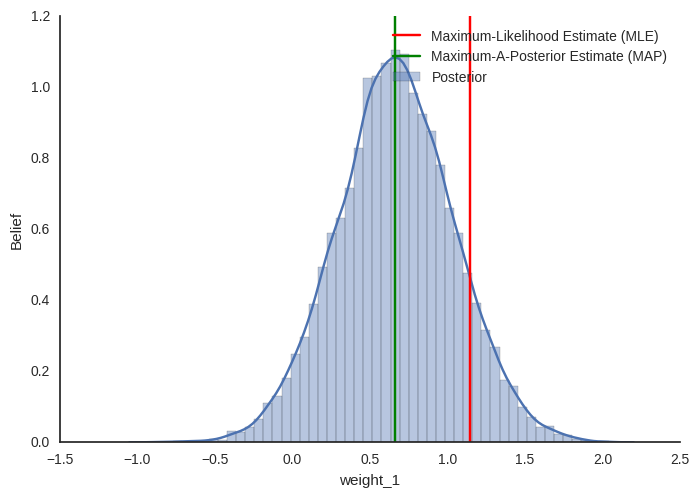

In [13]:
ax = sns.distplot(trace['w'][:, 0], label='Posterior')
ax.axvline(mle_est['w'][0], color='r', label='Maximum-Likelihood Estimate (MLE)')
ax.axvline(map_est['w'][0], color='g', label='Maximum-A-Posterior Estimate (MAP)')
ax.set(xlabel='weight_1', ylabel='Belief'); ax.legend(); sns.despine();

## Posterior Predictive

* Take parameter setting from posterior.
* Use parameter to classify.
* Repeat.

Result: Many predictions under various parameter settings -> uncertainty in prediction.

In [14]:
with perceptron_prior:
    # Creater posterior predictive samples
    ppc = pm.sample_ppc(trace, samples=500)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

In [15]:
pred = np.dot(X, map_est['w']) > .5
cont = T.nnet.sigmoid(np.dot(grid_2d, mle_est['w'])).eval()
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)

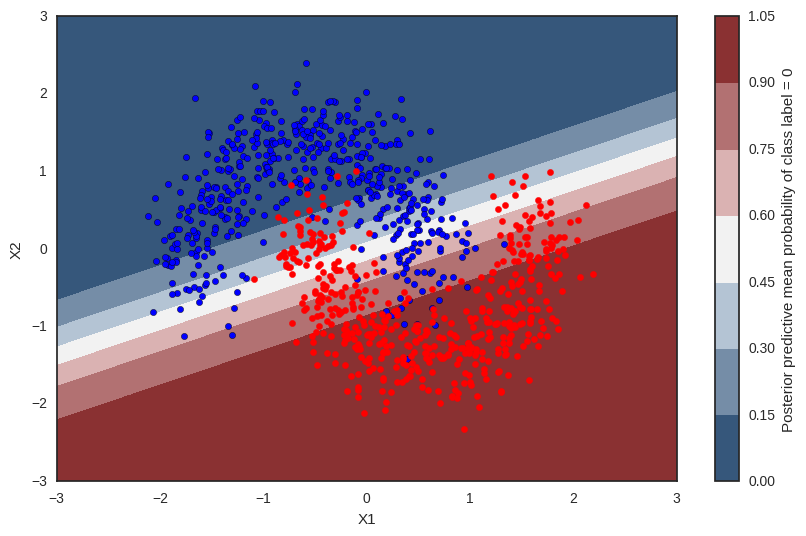

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, cont.reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [17]:
X_shared = theano.shared(X)
Y_shared = theano.shared(Y)

## Bayesian Neural Network

![](./ann.png)

In [18]:
from pymc3.math import tanh

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(n_dim, n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)
    
with pm.Model() as neural_network:
    ##########
    # Priors #
    ##########
    
    # Weights from input to hidden layer
    weights_in_1 = Normal('w_in_1', 0, sd=1, 
                          shape=(n_dim, n_hidden), 
                          testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = Normal('w_1_2', 0, sd=1, 
                         shape=(n_hidden, n_hidden), 
                         testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = Normal('w_2_out', 0, sd=1, 
                           shape=(n_hidden,), 
                           testval=init_out)
    
    #########################
    # Connecting the layers #
    #########################
    
    # Build neural-network using tanh activation function
    act_1 = tanh(dot(X_shared, weights_in_1))
    
    act_2 = tanh(dot(act_1, weights_1_2))
    
    class_prob = sigmoid(dot(act_2, weights_2_out))
    
    # Likelihood
    Bernoulli('out', class_prob, observed=Y_shared)

## Inference

In [19]:
%%time

with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = advi(n=100000)
    # Draw samples from posterior
    trace = sample_vp(v_params, draws=5000)
    
    # Creater posterior predictive samples
    ppc = pm.sample_ppc(trace, samples=500)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

Iteration 0 [0%]: ELBO = -652.51
Iteration 10000 [10%]: Average ELBO = -670.93
Iteration 20000 [20%]: Average ELBO = -386.07
Iteration 30000 [30%]: Average ELBO = -264.03
Iteration 40000 [40%]: Average ELBO = -199.39
Iteration 50000 [50%]: Average ELBO = -184.82
Iteration 60000 [60%]: Average ELBO = -181.72
Iteration 70000 [70%]: Average ELBO = -180.42
Iteration 80000 [80%]: Average ELBO = -179.8
Iteration 90000 [90%]: Average ELBO = -179.44
Finished [100%]: Average ELBO = -179.09
CPU times: user 54.9 s, sys: 8 ms, total: 54.9 s
Wall time: 54.6 s


## Lets look at what the classifier has learned

In [20]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

X_shared.set_value(grid_2d)
Y_shared.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

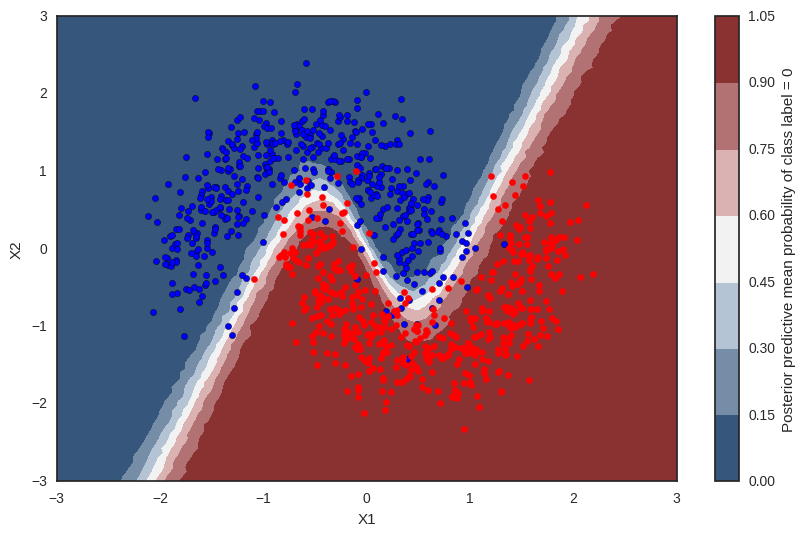

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

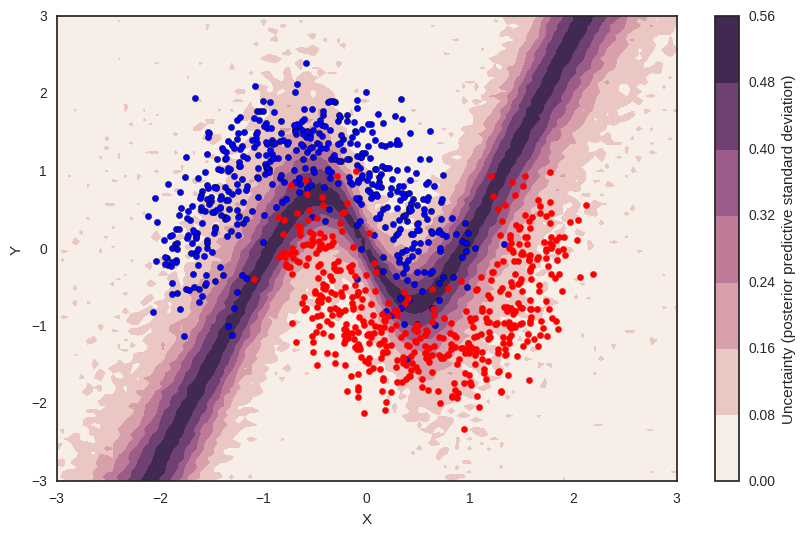

In [22]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[Y==0, 0], X[Y==0, 1])
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## Pretty cool, but...

still very toy model -- does it scale?

-- Yes! Check out https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/ where I use Lasagne and PyMC3 to train a Bayesian Convolutional Neural Net on MNIST.



## Cool, so we have uncertainty in our predictions, but...

is that it?

## Advanced Example from Algorithmic Trading

Switch back to slide 10 at https://docs.google.com/presentation/d/1puj4iN70MRVauUmIMAZS0pfANktjdQ5uCP7H8OLPKFk/edit?usp=sharing

In [23]:
X, Y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1)
X = scale(X)
colors = Y.astype(str)
colors[Y == 0] = 'r'
colors[Y == 1] = 'b'
sep_line = np.array([(3, 0), 
                     (0, -3)])

interval = 20
subsample = X.shape[0] // interval
chunk = np.arange(0, X.shape[0]+1, subsample)
degs = np.linspace(0, 360, len(chunk))

sep_lines = []

for ii, (i, j, deg) in enumerate(list(zip(np.roll(chunk, 1), chunk, degs))[1:]):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X[i:j, :] = X[i:j, :].dot(R)
    sep_lines.extend([sep_line.dot(R)] * subsample)

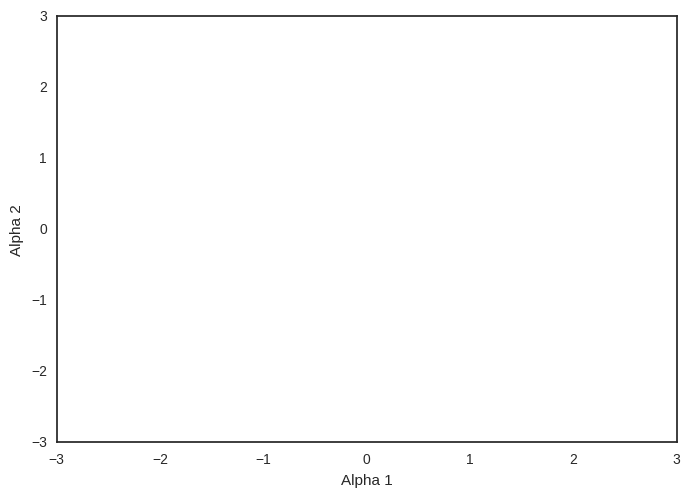

In [41]:
import base64
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""


def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save("test.mp4", fps=20, extra_args=['-vcodec', 'libx264'])

        video = open("test.mp4","rb").read()

    anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ims = [] #l, = plt.plot([], [], 'r-')
for i in np.arange(0, len(X), 10):
    ims.append((ax.scatter(X[:i, 0], X[:i, 1], color=colors[:i]),
                #ax.plot(sep_lines[i][:, 0], sep_lines[i][:, 1], color='b')[0],
               ))
    #ims.append((ax.plot(sep_lines[i][:, 0], sep_lines[i][:, 1], color='b'),))

ax.set(xlabel='Alpha 1', ylabel='Alpha 2')
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.ArtistAnimation(fig, ims,
                                 interval=500, 
                                 blit=True);

## Toy data set with non-stationarity

In [42]:
display_animation(anim)

## Placing a Random Walk prior on the weights

Before: $ w \sim \mathcal{N}(0, 1)$

Idea: $ w_t \sim \mathcal{N}(0, 1)$,
but weights would change erratically over time.

Better idea: $ w_t \sim \mathcal{N}(w_{t-1}, \sigma^2)$

$\sigma$ works like a step-size that controls how much $w_t$ can change from its previous value.

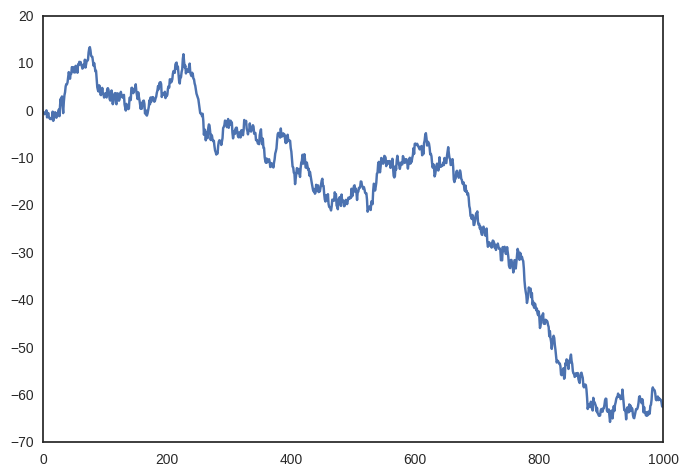

In [26]:
plt.plot(np.cumsum(np.random.randn(1000)));

## Perceptron with Changing Weights

In [27]:
from pymc3 import HalfNormal, GaussianRandomWalk
import theano.tensor as tt

n_dim = X.shape[1] # 2

with pm.Model() as random_walk_perceptron:
    step_size = HalfNormal('step_size', sd=1.)
    
    weights = GaussianRandomWalk('w', sd=step_size,
                                 shape=(len(Y), n_dim))
      
    class_prob = sigmoid(tt.batched_dot(X, weights))
    
    # Binary classification -> Bernoulli likelihood
    Bernoulli('out', class_prob, observed=Y)

Applied log-transform to step_size and added transformed step_size_log_ to model.


In [28]:
X_shared = theano.shared(X)
Y_shared = theano.shared(Y)

with pm.Model() as random_walk_perceptron:
    step_size = pm.HalfNormal('step_size', sd=np.array([1., 1]), 
                              shape=2)
    
    w = pm.GaussianRandomWalk('w', sd=step_size, 
                              shape=(interval, 2))
    
    weights = tt.repeat(w, X_shared.shape[0] // interval, axis=0)
    
    class_prob = sigmoid(tt.batched_dot(X_shared, weights))
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('out', class_prob, observed=Y_shared)

Applied log-transform to step_size and added transformed step_size_log_ to model.


In [29]:
from pymc3 import NUTS, advi
with random_walk_perceptron:
    # Run ADVI to initialize
    v_params = advi(n=100000)
    step = NUTS(scaling=random_walk_perceptron.dict_to_array(v_params.stds), 
                is_cov=True)
    trace = pm.sample(2000, step, start=v_params.means)

Iteration 0 [0%]: ELBO = -832.73
Iteration 10000 [10%]: Average ELBO = -428.13
Iteration 20000 [20%]: Average ELBO = -104.0
Iteration 30000 [30%]: Average ELBO = -94.97
Iteration 40000 [40%]: Average ELBO = -93.02
Iteration 50000 [50%]: Average ELBO = -92.14
Iteration 60000 [60%]: Average ELBO = -91.63
Iteration 70000 [70%]: Average ELBO = -91.5
Iteration 80000 [80%]: Average ELBO = -91.27
Iteration 90000 [90%]: Average ELBO = -91.1
Finished [100%]: Average ELBO = -91.0


100%|██████████| 2000/2000 [00:52<00:00, 38.06it/s]


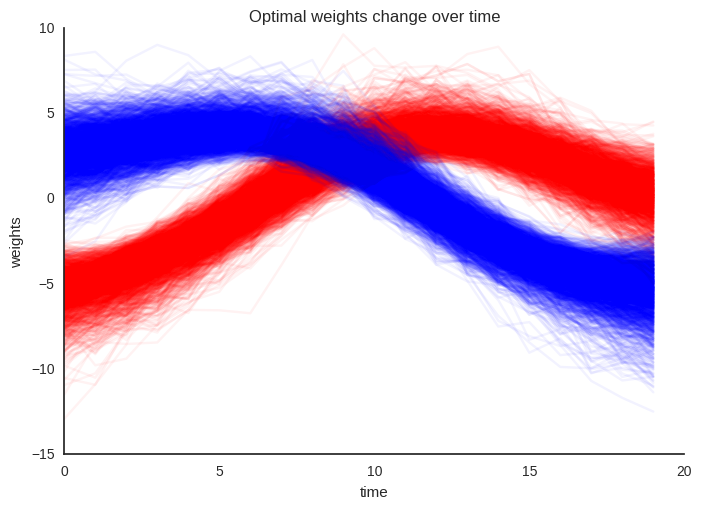

In [30]:
plt.plot(trace['w'][:, :, 0].T, alpha=.05, color='r');
plt.plot(trace['w'][:, :, 1].T, alpha=.05, color='b');
plt.xlabel('time'); plt.ylabel('weights'); plt.title('Optimal weights change over time'); sns.despine();

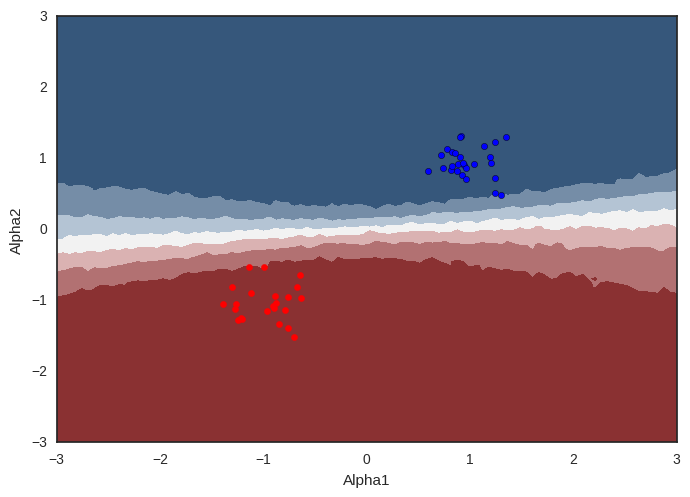

In [32]:
# grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
grid_2d = np.tile(grid_2d, (interval, 1))
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

X_shared.set_value(grid_2d)
Y_shared.set_value(dummy_out)

import types

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=random_walk_perceptron, samples=500)

def create_surface(X, Y, grid, ppc, fig=None, ax=None):
    artists = []
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    #ax = fig.add_subplot(111)
    contour = ax.contourf(*grid, ppc, cmap=cmap)
    artists.extend(contour.collections)
    artists.append(ax.scatter(X[Y==0, 0], X[Y==0, 1]))
    artists.append(ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r'))
    #cbar = plt.colorbar(contour, ax=ax)
    _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='Alpha1', ylabel='Alpha2');
    #cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');
    return artists

fig, ax = plt.subplots() #plt.figure()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].mean(axis=0).reshape(100, 100), fig=fig, ax=ax)
    axs.append(a)

In [39]:
anim2 = animation.ArtistAnimation(fig, axs,
                                 interval=1000);

In [40]:
display_animation(anim2)

In [3]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=ODSC_London_2016_Probabilistic_ML_Wiecki \
    ./probabilistic_ml.ipynb

[NbConvertApp] Converting notebook ./probabilistic_ml.ipynb to slides
[NbConvertApp] Writing 1206643 bytes to ./ODSC_London_2016_Probabilistic_ML_Wiecki.slides.html
